# **DATASET IMPORT AND PREPROCESSING**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.preprocessing import LabelEncoder
import string
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [6]:
# Load the datasets
posts1 = pd.read_csv("data/social_media_posts 1.csv")
profiles1 = pd.read_csv("data/user_profiles 1.csv")
features1 = pd.read_csv("data/content_features 1.csv")
posts = pd.read_csv("data/social_media_posts.csv")
users = pd.read_csv("data/user_profiles.csv")
features = pd.read_csv("data/content_features.csv")





In [7]:
# Merge features into posts
data = posts.merge(features, on='post_id', how='left')
# Merge user profile data
data = data.merge(users, on='user_id', how='left')
data.head()


,post_id,user_id,platform,likes,shares,comments,text_content,label,sentiment_score,contains_link,contains_hashtag,location,device,verified
0,post_1,user_103,Facebook,299,54,28,Solar disinfection of water proves effective.,Legitimate,0.14,1,1,Kigali,iOS,False
1,post_2,user_271,TikTok,224,119,32,Rainwater harvesting gains popularity in Uganda.,Legitimate,0.03,0,1,Nairobi,Tablet,False
2,post_3,user_107,TikTok,129,74,61,NaN,Legitimate,0.05,1,1,Addis Ababa,Tablet,False
3,post_4,user_72,TikTok,64,20,14,Clean water access has improved in rural Kenya.,Legitimate,-0.64,1,0,Addis Ababa,iOS,True
4,post_5,user_189,Reddit,36,132,1,Water kiosks now serve clean water in Nairobi.,Legitimate,-0.01,0,0,Addis Ababa,Desktop,False


In [8]:
data.shape

(1000, 14)

In [9]:
data.size

14000

In [10]:
data.columns

Index(['post_id', 'user_id', 'platform', 'likes', 'shares', 'comments',
       'text_content', 'label', 'sentiment_score', 'contains_link',
       'contains_hashtag', 'location', 'device', 'verified'],
      dtype='object')

In [11]:
missing_summary = data.isnull().sum().sort_values(ascending=False)
print("Missing Value Summary:\n", missing_summary)


Missing Value Summary:
 verified            47
text_content        43
location            36
device              32
post_id              0
user_id              0
comments             0
shares               0
likes                0
platform             0
contains_link        0
sentiment_score      0
label                0
contains_hashtag     0
dtype: int64


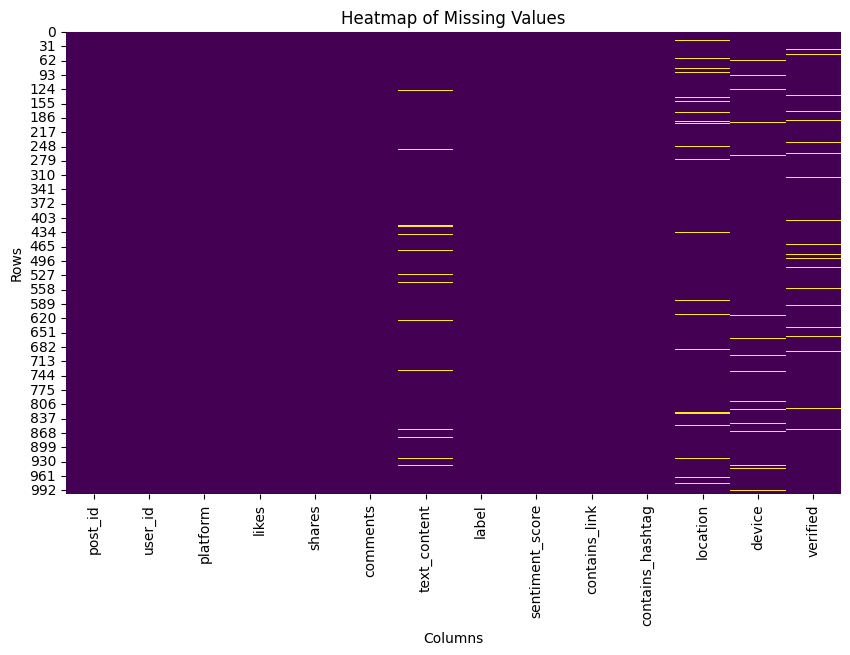

In [12]:
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

# handling missing values

In [13]:
# Fill missing text with "unknown"
data['text_content'].fillna("unknown", inplace=True)

# Fill missing location/device with 'Unknown'
data['location'].fillna('Unknown', inplace=True)
data['device'].replace('', 'Unknown', inplace=True)

# Fill missing verified status with mode
data['verified'].fillna(data['verified'].mode()[0], inplace=True)


C:\Users\admin\AppData\Local\Temp\ipykernel_3088\3092826095.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['text_content'].fillna("unknown", inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_3088\3092826095.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

In [14]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)               # remove links
    text = re.sub(r"@\w+", "", text)                  # remove mentions
    text = re.sub(r"#\w+", "", text)                  # remove hashtags
    text = re.sub(r"[^\w\s]", "", text)               # remove punctuation
    text = re.sub(r"\d+", "", text)                   # remove numbers
    text = re.sub(r"\s+", " ", text).strip()          # remove extra spaces
    return text

data['clean_text'] = data['text_content'].apply(clean_text)


# Nlp Data preprocessing

In [15]:
le_platform = LabelEncoder()
le_device = LabelEncoder()

data['platform_encoded'] = le_platform.fit_transform(data['platform'])
data['device_encoded'] = le_device.fit_transform(data['device'])
data['verified_encoded'] = data['verified'].astype(int)


In [16]:
label_map = {'Misinformation': 1, 'Legitimate': 0}
data['target'] = data['label'].map(label_map)


Text(0, 0.5, 'Frequency')

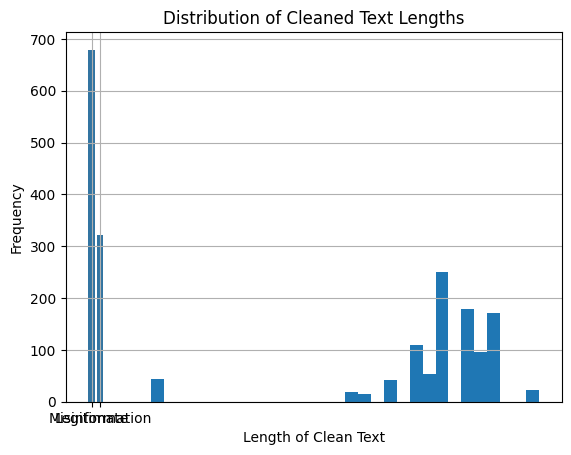

In [17]:
# Class balance
sns.countplot(x='label', data=data)
plt.title("Label Distribution")

# Text length distribution
data['text_length'] = data['clean_text'].apply(len)
data['text_length'].hist(bins=30)
plt.title("Distribution of Cleaned Text Lengths")
plt.xlabel("Length of Clean Text")
plt.ylabel("Frequency")


In [18]:
# Keep selected features for modeling
final_df = data[['clean_text', 'likes', 'shares', 'comments',
               'sentiment_score', 'contains_link', 'contains_hashtag',
               'platform_encoded', 'device_encoded', 'verified_encoded', 'target']]

final_df.to_csv("cleaned_misinformation_dataset.csv", index=False)
print("Dataset saved.")


Dataset saved.


## EDA in 15 Python Cells (with visualizations)

In [19]:
!pip install wordcloud


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
df = pd.read_csv("cleaned_misinformation_dataset.csv")



In [57]:
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
Index: 911 entries, 0 to 999
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   post_id          911 non-null    int64  
 1   user_id          911 non-null    int64  
 2   likes            911 non-null    float64
 3   shares           911 non-null    float64
 4   comments         911 non-null    float64
 5   label            911 non-null    object 
 6   text             911 non-null    object 
 7   age              911 non-null    float64
 8   gender           911 non-null    int64  
 9   location         911 non-null    int64  
 10  verified         911 non-null    int64  
 11  join_date        911 non-null    object 
 12  text_length      911 non-null    int64  
 13  has_image        911 non-null    int64  
 14  has_video        911 non-null    float64
 15  sentiment_score  911 non-null    float64
 16  clean_text       911 non-null    object 
dtypes: float64(6), int64(

,post_id,user_id,likes,shares,comments,label,text,age,gender,location,verified,join_date,text_length,has_image,has_video,sentiment_score,clean_text
count,911.000000,911.000000,911.000000,911.000000,911.000000,911,911,911.000000,911.000000,911.000000,911.000000,911,911.000000,911.000000,911.000000,911.000000,911
unique,NaN,NaN,NaN,NaN,NaN,2,32,NaN,NaN,NaN,NaN,280,NaN,NaN,NaN,NaN,32
top,NaN,NaN,NaN,NaN,NaN,Legitimate,Experts debate the safety of boiling water.,NaN,NaN,NaN,NaN,2016-11-17,NaN,NaN,NaN,NaN,experts debate safety boiling water
freq,NaN,NaN,NaN,NaN,NaN,632,55,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,55
mean,501.140505,151.212953,25.049396,6.397366,2.801317,NaN,NaN,38.849616,0.669594,5.002195,0.170143,NaN,148.795829,0.567508,0.318332,0.193238,NaN
std,290.409306,85.603948,9.048998,4.463793,2.295968,NaN,NaN,15.268455,0.702857,3.034236,0.375965,NaN,73.877832,0.495694,0.466085,0.578364,NaN
min,1.000000,1.000000,0.000000,-3.000000,-2.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,20.000000,0.000000,0.000000,-1.540000,NaN
25%,250.500000,79.500000,21.000000,3.000000,1.000000,NaN,NaN,26.000000,0.000000,2.500000,0.000000,NaN,85.500000,0.000000,0.000000,-0.180000,NaN
50%,495.000000,151.000000,26.000000,6.000000,3.000000,NaN,NaN,41.000000,1.000000,5.000000,0.000000,NaN,147.000000,1.000000,0.000000,0.170000,NaN
75%,757.500000,225.000000,31.000000,10.000000,4.000000,NaN,NaN,52.000000,1.000000,7.000000,0.000000,NaN,211.000000,1.000000,1.000000,0.605000,NaN


Text(0, 0.5, 'Count')

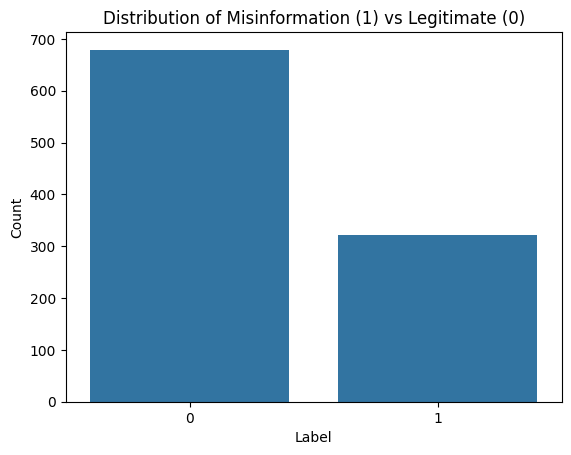

In [22]:
sns.countplot(x='target', data=df)
plt.title("Distribution of Misinformation (1) vs Legitimate (0)")
plt.xlabel("Label")
plt.ylabel("Count")


Text(0.5, 0.98, 'Engagement Metric Distributions')

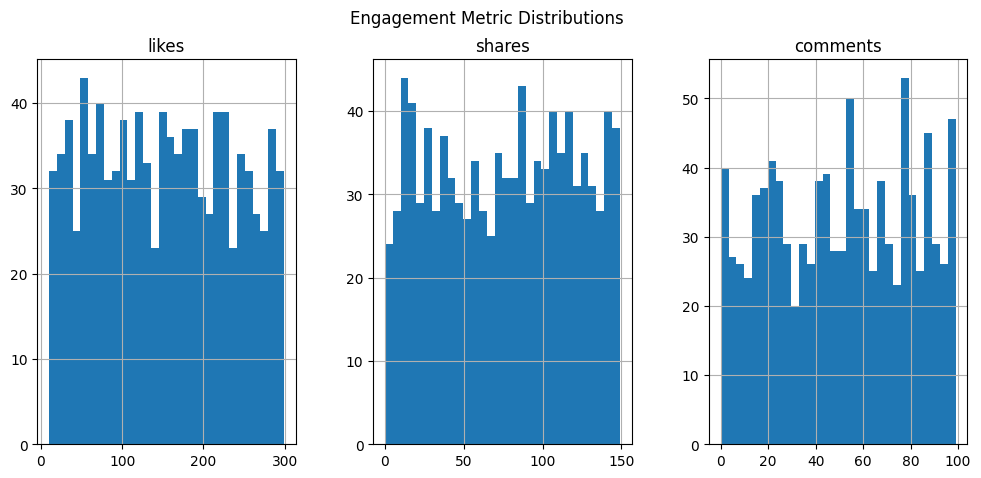

In [23]:
engagement_cols = ['likes', 'shares', 'comments']
df[engagement_cols].hist(bins=30, figsize=(12, 5), layout=(1, 3))
plt.suptitle("Engagement Metric Distributions")


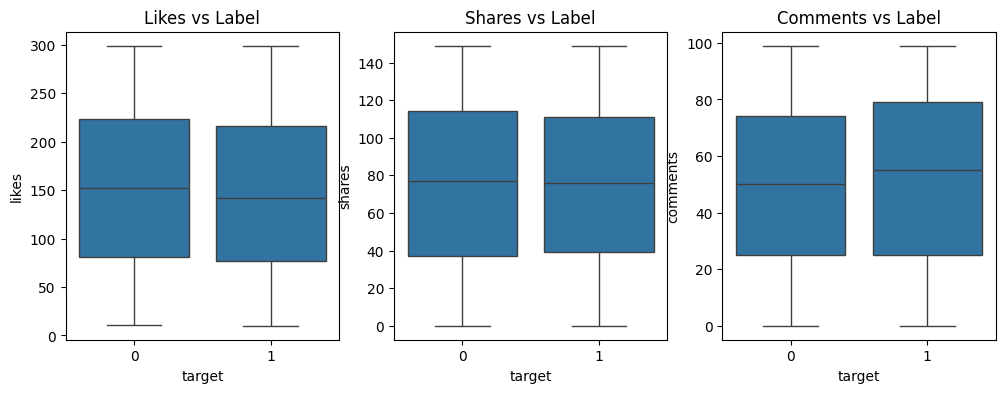

In [24]:
plt.figure(figsize=(12, 4))
for i, col in enumerate(engagement_cols):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='target', y=col, data=df)
    plt.title(f'{col.capitalize()} vs Label')


Text(0.5, 1.0, 'Sentiment Score Distribution')

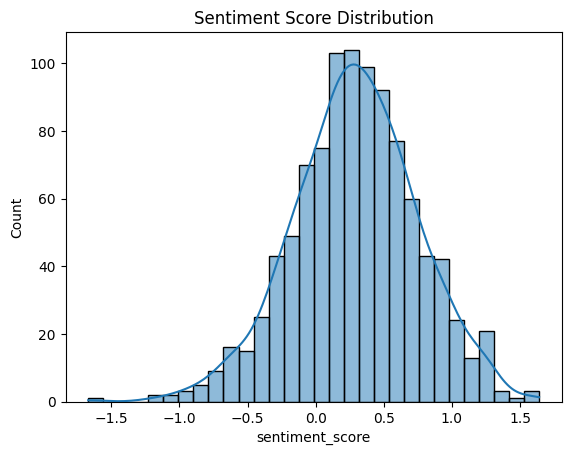

In [25]:
sns.histplot(df['sentiment_score'], kde=True, bins=30)
plt.title("Sentiment Score Distribution")


Text(0.5, 1.0, 'Sentiment Score by Label')

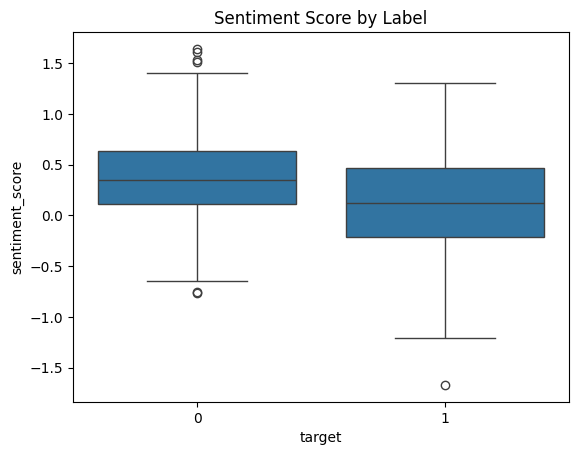

In [26]:
sns.boxplot(x='target', y='sentiment_score', data=df)
plt.title("Sentiment Score by Label")


Text(0.5, 1.0, 'Link Usage by Label')

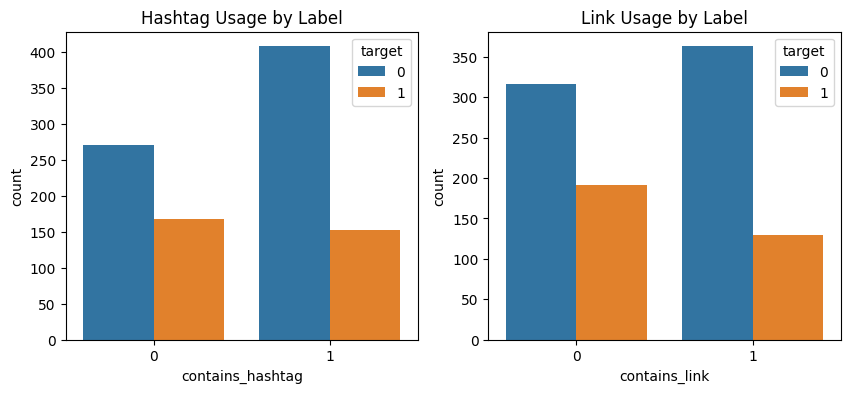

In [27]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.countplot(x='contains_hashtag', hue='target', data=df)
plt.title("Hashtag Usage by Label")

plt.subplot(1, 2, 2)
sns.countplot(x='contains_link', hue='target', data=df)
plt.title("Link Usage by Label")


Text(0.5, 1.0, 'Clean Text Length Distribution by Label')

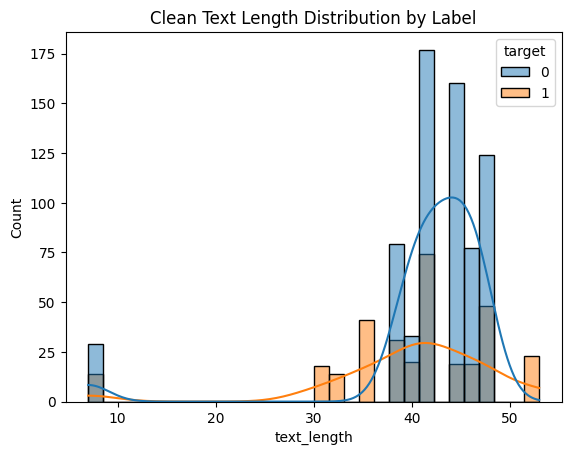

In [28]:
df['text_length'] = df['clean_text'].apply(len)
sns.histplot(data=df, x='text_length', hue='target', bins=30, kde=True)
plt.title("Clean Text Length Distribution by Label")


Text(0.5, 0, 'Platform (encoded)')

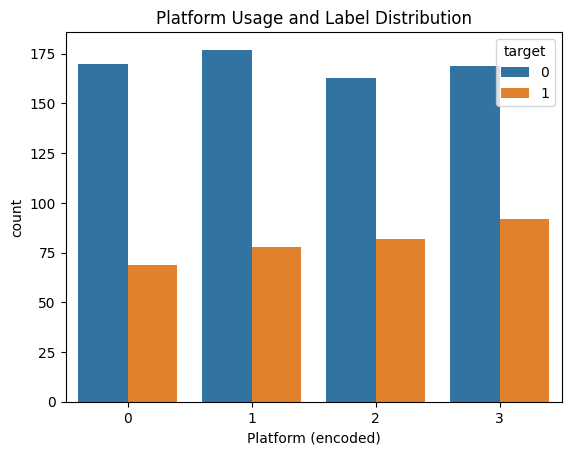

In [29]:
platform_map = {v: k for k, v in enumerate(df['platform_encoded'].unique())}
sns.countplot(x='platform_encoded', hue='target', data=df)
plt.title("Platform Usage and Label Distribution")
plt.xlabel("Platform (encoded)")


Text(0.5, 0, 'Device Type (encoded)')

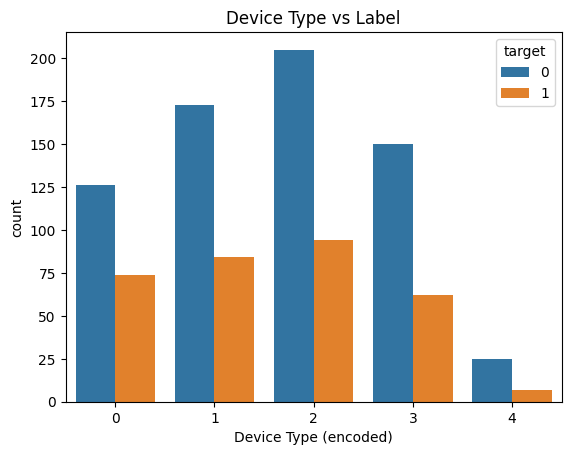

In [30]:
sns.countplot(x='device_encoded', hue='target', data=df)
plt.title("Device Type vs Label")
plt.xlabel("Device Type (encoded)")


Text(0.5, 1.0, 'WordCloud: Legitimate Posts')

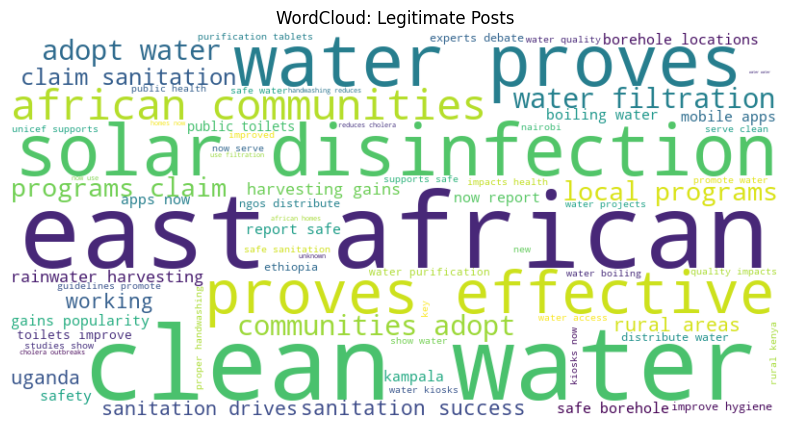

In [31]:
from wordcloud import WordCloud
legit_text = " ".join(df[df['target']==0]['clean_text'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(legit_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud: Legitimate Posts")


Text(0.5, 1.0, 'WordCloud: Misinformation Posts')

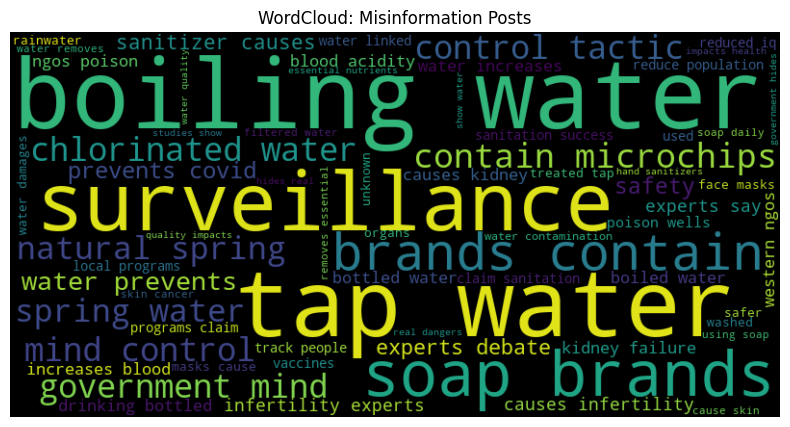

In [32]:
misinfo_text = " ".join(df[df['target']==1]['clean_text'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(misinfo_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud: Misinformation Posts")


Text(0.5, 1.0, 'Feature Correlation Heatmap')

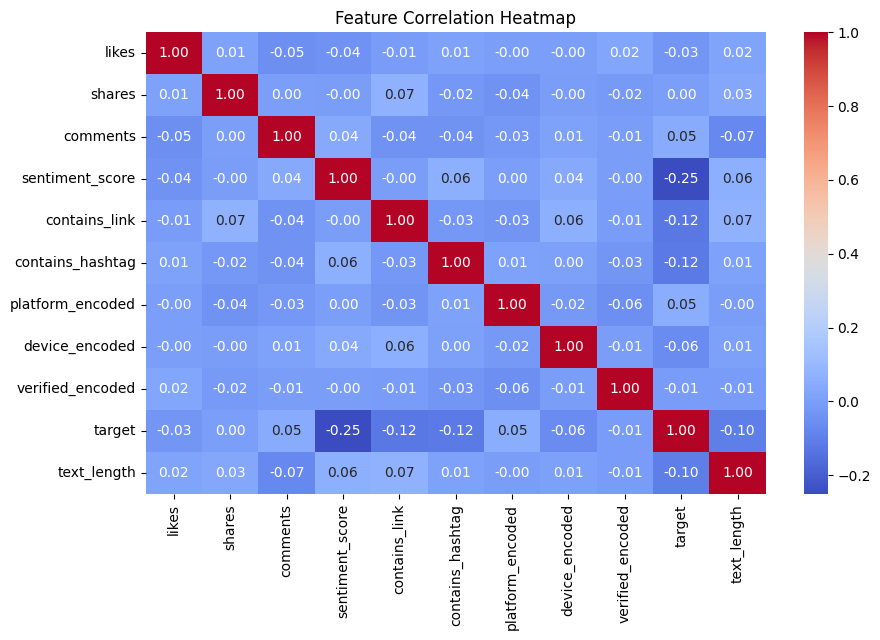

In [33]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")


#

# **MACHINE LEARNING MODELS IMPLEMNTATAIONS**

In [37]:
posts1.head()

,post_id,user_id,timestamp,likes,shares,comments,label,text
0,1,103,2023-01-01 00:00:00,33.0,5.0,4.0,Legitimate,Studies show water quality impacts health.
1,2,271,2023-01-01 01:00:00,31.0,5.0,-1.0,Legitimate,Rainwater harvesting gains popularity in Uganda.
2,3,107,2023-01-01 02:00:00,32.0,3.0,NaN,Legitimate,Clean water access has improved in rural Kenya.
3,4,72,2023-01-01 03:00:00,27.0,5.0,4.0,Legitimate,Local programs claim sanitation success.
4,5,189,2023-01-01 04:00:00,25.0,0.0,3.0,Legitimate,Experts debate the safety of boiling water.


In [41]:
features1.head()

,post_id,text_length,has_image,has_video,sentiment_score
0,1,44,1,0.0,NaN
1,2,98,0,0.0,1.07
2,3,87,1,1.0,0.24
3,4,192,0,0.0,0.41
4,5,31,0,0.0,0.31


In [40]:
profiles1.head()

,user_id,age,gender,location,verified,join_date
0,1,56.0,Male,Mombasa,False,2015-01-01
1,2,46.0,Female,Juba,False,2015-01-08
2,3,32.0,Male,Arusha,False,2015-01-15
3,4,60.0,Male,Nairobi,True,2015-01-22
4,5,25.0,Female,Kigali,False,2015-01-29


In [42]:
# Merge datasets
merged_df = posts1.merge(profiles1, on='user_id', how='left')
merged_df = merged_df.merge(features1, on='post_id', how='left')


In [43]:
del merged_df["timestamp"]

In [44]:

import re
import string
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# --- Step 1: Download required NLTK data ---
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

# --- Step 2: Load Data ---
df = merged_df.copy()

# --- Step 3: Clean target variable ---
target_col = 'label'
df = df[df[target_col].notna()]
df[target_col] = df[target_col].astype(str)

# --- Step 4: NLP Text Cleaning ---
def clean_text(text):
    if pd.isnull(text) or not isinstance(text, str):
        return ""
    
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\@\w+|\#', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    tokens = word_tokenize(text)
    filtered = [w for w in tokens if w not in stop_words and len(w) > 2]
    
    return ' '.join(filtered) if filtered else "placeholder"

df['clean_text'] = df['text'].apply(clean_text)
df = df[df['clean_text'].str.strip().astype(bool)]  # Remove completely empty rows

# --- Step 5: TF-IDF Vectorization ---
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_text = tfidf.fit_transform(df['clean_text'])

# --- Step 6: Encode Categorical Features ---
label_encoders = {}
categorical_cols = ['gender', 'location']
for col in categorical_cols:
    df[col] = df[col].fillna("Unknown")
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# --- Step 7: Fill numeric features ---
numeric_cols = ['likes', 'shares', 'comments', 'age', 'text_length', 'has_image', 'has_video', 'sentiment_score']
df[numeric_cols] = df[numeric_cols].fillna(0)

# --- Step 8: Boolean features ---
df['verified'] = df['verified'].astype(int)

# --- Step 9: Combine features ---
X_numeric = df[numeric_cols + ['gender', 'location', 'verified']]
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

from scipy.sparse import hstack
X_combined = hstack([X_text, X_numeric_scaled])
y = df[target_col]

# --- Step 10: Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

# --- Step 11: Train Model ---
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# --- Step 12: Evaluate ---
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                precision    recall  f1-score   support

    Legitimate       0.96      0.98      0.97       127
Misinformation       0.96      0.91      0.94        56

      accuracy                           0.96       183
     macro avg       0.96      0.95      0.95       183
  weighted avg       0.96      0.96      0.96       183



In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_fscore_support
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize

# Prepare data
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

unique_classes = np.unique(y)
n_classes = len(unique_classes)

metrics_list = []
model_predictions = {}


# logistic regression


Logistic Regression
--------------------
                precision    recall  f1-score   support

    Legitimate       0.96      0.98      0.97       127
Misinformation       0.96      0.91      0.94        56

      accuracy                           0.96       183
     macro avg       0.96      0.95      0.95       183
  weighted avg       0.96      0.96      0.96       183



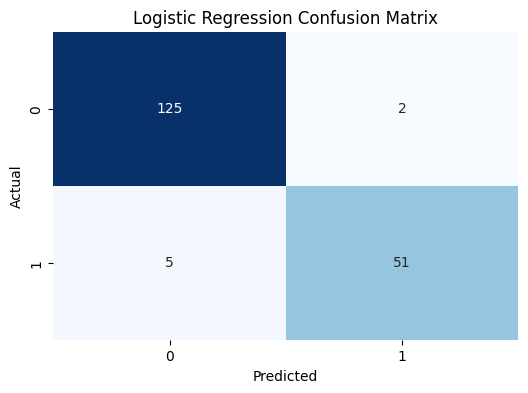

In [46]:
# --- Logistic Regression ---
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Store predictions
model_predictions["Logistic Regression"] = y_pred

# Metrics and report
print("\nLogistic Regression\n" + "-"*20)
print(classification_report(y_test, y_pred))

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="macro")
accuracy = np.mean(y_test == y_pred)

if hasattr(model, "predict_proba"):
    y_proba = model.predict_proba(X_test)
    if n_classes == 2:
        roc_auc = roc_auc_score(y_test, y_proba[:, 1])
    else:
        y_test_bin = label_binarize(y_test, classes=unique_classes)
        roc_auc = roc_auc_score(y_test_bin, y_proba, multi_class='ovr')
else:
    roc_auc = float('nan')

metrics_list.append({
    "Model": "Logistic Regression",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1,
    "ROC-AUC": roc_auc
})

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# random forest


Random Forest
-----------
                precision    recall  f1-score   support

    Legitimate       0.99      0.99      0.99       127
Misinformation       0.98      0.98      0.98        56

      accuracy                           0.99       183
     macro avg       0.99      0.99      0.99       183
  weighted avg       0.99      0.99      0.99       183



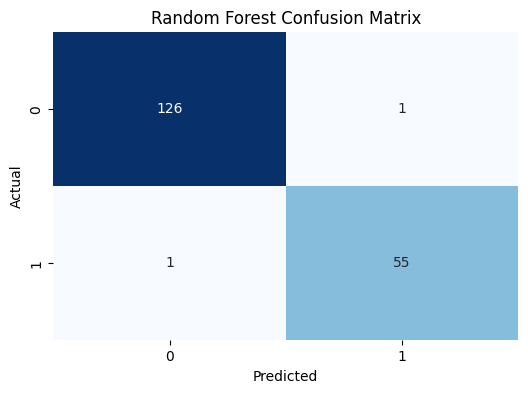

In [47]:
# --- Random Forest ---
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

model_predictions["Random Forest"] = y_pred

print("\nRandom Forest\n" + "-"*11)
print(classification_report(y_test, y_pred))

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="macro")
accuracy = np.mean(y_test == y_pred)

if hasattr(model, "predict_proba"):
    y_proba = model.predict_proba(X_test)
    if n_classes == 2:
        roc_auc = roc_auc_score(y_test, y_proba[:, 1])
    else:
        y_test_bin = label_binarize(y_test, classes=unique_classes)
        roc_auc = roc_auc_score(y_test_bin, y_proba, multi_class='ovr')
else:
    roc_auc = float('nan')

metrics_list.append({
    "Model": "Random Forest",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1,
    "ROC-AUC": roc_auc
})

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# SVM


SVM (Linear)
-----------
                precision    recall  f1-score   support

    Legitimate       0.97      0.98      0.98       127
Misinformation       0.96      0.93      0.95        56

      accuracy                           0.97       183
     macro avg       0.97      0.96      0.96       183
  weighted avg       0.97      0.97      0.97       183



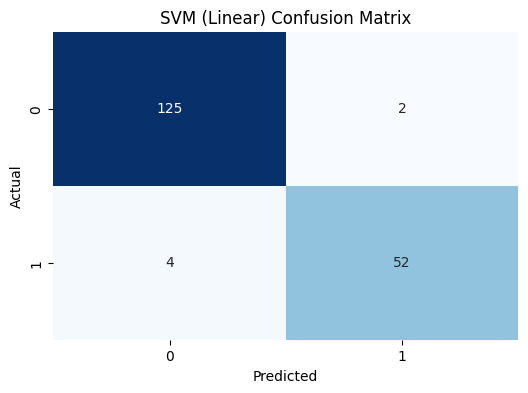

In [49]:
# --- SVM (Linear) ---
model = SVC(kernel='linear', probability=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

model_predictions["SVM (Linear)"] = y_pred

print("\nSVM (Linear)\n" + "-"*11)
print(classification_report(y_test, y_pred))

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="macro")
accuracy = np.mean(y_test == y_pred)

if hasattr(model, "predict_proba"):
    y_proba = model.predict_proba(X_test)
    if n_classes == 2:
        roc_auc = roc_auc_score(y_test, y_proba[:, 1])
    else:
        y_test_bin = label_binarize(y_test, classes=unique_classes)
        roc_auc = roc_auc_score(y_test_bin, y_proba, multi_class='ovr')
else:
    roc_auc = float('nan')

metrics_list.append({
    "Model": "SVM (Linear)",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1,
    "ROC-AUC": roc_auc
})

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("SVM (Linear) Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Gradient Boosting


Gradient Boosting
-----------------
                precision    recall  f1-score   support

    Legitimate       0.98      0.98      0.98       127
Misinformation       0.95      0.95      0.95        56

      accuracy                           0.97       183
     macro avg       0.96      0.96      0.96       183
  weighted avg       0.97      0.97      0.97       183



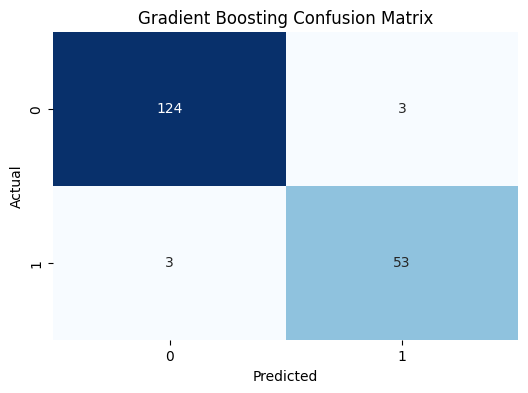

In [48]:
# --- Gradient Boosting ---
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

model_predictions["Gradient Boosting"] = y_pred

print("\nGradient Boosting\n" + "-"*17)
print(classification_report(y_test, y_pred))

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="macro")
accuracy = np.mean(y_test == y_pred)

if hasattr(model, "predict_proba"):
    y_proba = model.predict_proba(X_test)
    if n_classes == 2:
        roc_auc = roc_auc_score(y_test, y_proba[:, 1])
    else:
        y_test_bin = label_binarize(y_test, classes=unique_classes)
        roc_auc = roc_auc_score(y_test_bin, y_proba, multi_class='ovr')
else:
    roc_auc = float('nan')

metrics_list.append({
    "Model": "Gradient Boosting",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1,
    "ROC-AUC": roc_auc
})

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Gradient Boosting Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Naive Bayes

In [ ]:
# --- Naive Bayes ---
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

model_predictions["Naive Bayes"] = y_pred

print("\nNaive Bayes\n" + "-"*10)
print(classification_report(y_test, y_pred))

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="macro")
accuracy = np.mean(y_test == y_pred)

if hasattr(model, "predict_proba"):
    y_proba = model.predict_proba(X_test)
    if n_classes == 2:
        roc_auc = roc_auc_score(y_test, y_proba[:, 1])
    else:
        y_test_bin = label_binarize(y_test, classes=unique_classes)
        roc_auc = roc_auc_score(y_test_bin, y_proba, multi_class='ovr')
else:
    roc_auc = float('nan')

metrics_list.append({
    "Model": "Naive Bayes",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1,
    "ROC-AUC": roc_auc
})

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Naive Bayes Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Comparison plots and predicted vs actual

                 Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC
1        Random Forest  0.989071   0.987134  0.987134  0.987134  0.998875
2    Gradient Boosting  0.967213   0.961403  0.961403  0.961403  0.994938
3         SVM (Linear)  0.967213   0.965978  0.956412  0.961009  0.993813
0  Logistic Regression  0.961749   0.961901  0.947483  0.954271  0.988892


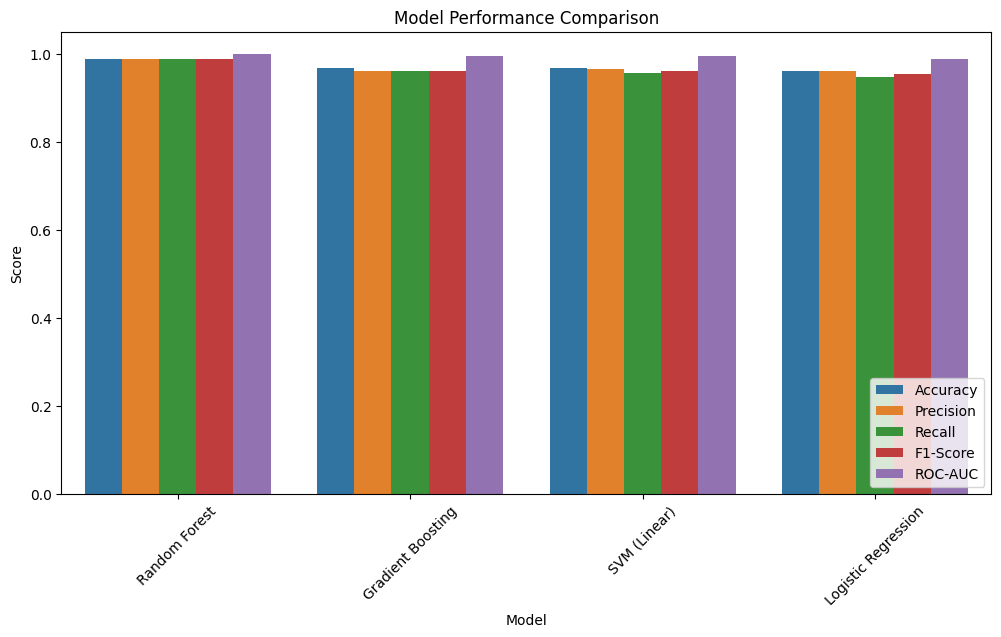

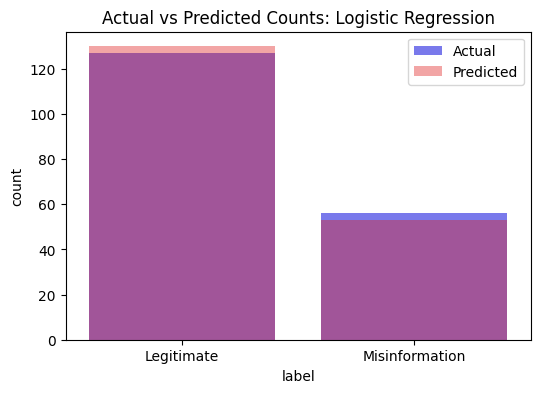

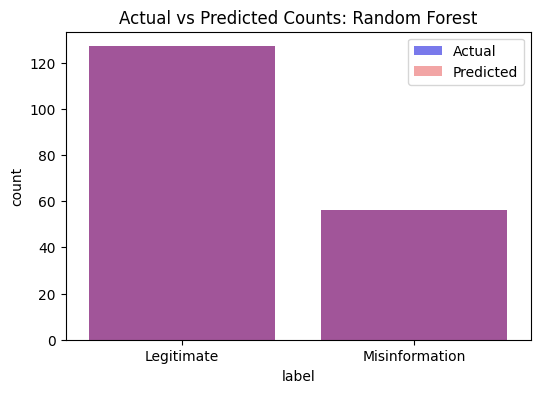

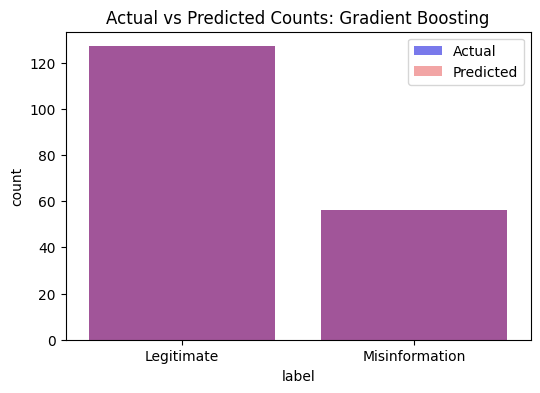

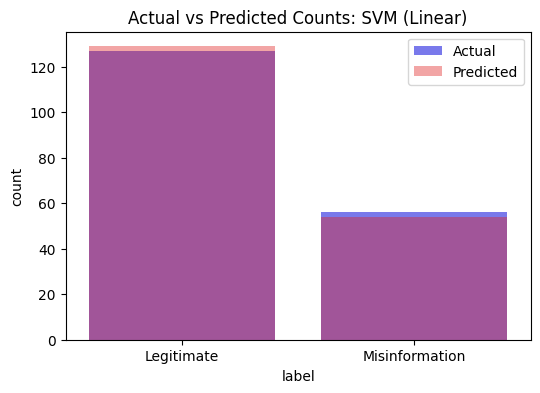

In [50]:
# --- Comparison Plots for All Models ---

metrics_df = pd.DataFrame(metrics_list).sort_values(by="F1-Score", ascending=False)
print(metrics_df)

# Bar plot for metrics comparison
plt.figure(figsize=(12,6))
metrics_df_melted = metrics_df.melt(id_vars="Model", value_vars=["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"])
sns.barplot(data=metrics_df_melted, x="Model", y="value", hue="variable")
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.legend(loc="lower right")
plt.xticks(rotation=45)
plt.show()

# Predicted vs Actual counts plot for each model
for model_name, y_pred in model_predictions.items():
    plt.figure(figsize=(6,4))
    sns.countplot(x=y_test, color='blue', label='Actual', alpha=0.6)
    sns.countplot(x=y_pred, color='red', label='Predicted', alpha=0.4)
    plt.title(f"Actual vs Predicted Counts: {model_name}")
    plt.legend()
    plt.show()


# Selected model
## **Random Forest**
**Random Forest is the best model because it achieves the highest accuracy, precision, recall, F1-score, and ROC-AUC, indicating superior overall** **performance and robustness compared to the other models.**

In [51]:
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

X = df['text']       
y = df['label']      

# Split data
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with Tfidf and Random Forest
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the model
pipeline.fit(X_train_raw, y_train)

# Save the pipeline
with open('misinfo_model.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

print("✅ Model pipeline trained and saved as 'misinfo_model.pkl'")


✅ Model pipeline trained and saved as 'misinfo_model.pkl'


# SAMPLE TEST OF THE SELECTED MODEL 

In [52]:
import pickle

# Load the trained pipeline
with open('misinfo_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Sample test texts
test_texts = [
    "Studies show water quality impacts health.",
    "Rainwater harvesting gains popularity in Uganda.",
    "Clean water access has improved in rural Kenya.",
    "Local programs claim sanitation success.",
    "Experts debate the safety of boiling water.",
    "Water kiosks now serve clean water in Nairobi.",
    "Sanitizer causes infertility, experts say.",
    "",  # Represents NaN or empty text
    "Vaccines in water are used to track people.",
    "Proper handwashing reduces cholera outbreaks."
]

# Predict using the loaded model
predictions = model.predict(test_texts)

# Print results
for text, label in zip(test_texts, predictions):
    print(f"Input: {text}\nPrediction: {label}\n{'-'*60}")


Input: Studies show water quality impacts health.
Prediction: Legitimate
------------------------------------------------------------
Input: Rainwater harvesting gains popularity in Uganda.
Prediction: Legitimate
------------------------------------------------------------
Input: Clean water access has improved in rural Kenya.
Prediction: Legitimate
------------------------------------------------------------
Input: Local programs claim sanitation success.
Prediction: Legitimate
------------------------------------------------------------
Input: Experts debate the safety of boiling water.
Prediction: Legitimate
------------------------------------------------------------
Input: Water kiosks now serve clean water in Nairobi.
Prediction: Legitimate
------------------------------------------------------------
Input: Sanitizer causes infertility, experts say.
Prediction: Misinformation
------------------------------------------------------------
Input: 
Prediction: Legitimate
-------------

 # **MODEL DEPLOYMENT** 
 **THE RANDOM FOREST  MODEL INTERGRATED WITH GOOGLE API SUCH THAT THE USER CAN LEARN MORE ABOUT THE NEWS/INFORMATION TO BE PREDICTED**

In [ ]:
import pickle
from flask import Flask, render_template_string, request
import webbrowser
import urllib.parse


with open('misinfo_model.pkl', 'rb') as f:
    model = pickle.load(f)

app = Flask(__name__)


html_template = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8" />
    <meta name="viewport" content="width=device-width, initial-scale=1" />
    <title>Disinformation Detection System</title>
    <link href="https://cdn.jsdelivr.net/npm/bootstrap@4.6.2/dist/css/bootstrap.min.css" rel="stylesheet" />
    <style>
        body {
            background: #f2f8ff;
            display: flex;
            justify-content: center;
            align-items: center;
            min-height: 100vh;
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            margin: 0;
            padding: 20px;
        }
        .container {
            background: #ffffff;
            border-radius: 12px;
            box-shadow: 0 10px 30px rgba(0,0,0,0.1);
            max-width: 700px;
            width: 100%;
            padding: 30px 40px;
        }
        h1 {
            text-align: center;
            margin-bottom: 25px;
            color: #007bff;
            font-weight: 700;
            letter-spacing: 1px;
        }
        textarea {
            resize: none;
            font-size: 1rem;
        }
        .btn-custom {
            background: #007bff;
            border: none;
            color: white;
            font-weight: 600;
            transition: background 0.3s ease;
        }
        .btn-custom:hover {
            background: #0056b3;
        }
        .result-box {
            background: #e6f0ff;
            border-left: 5px solid #007bff;
            padding: 15px 20px;
            margin-top: 25px;
            border-radius: 8px;
            word-wrap: break-word;
        }
        .label-text {
            font-weight: 600;
            color: #222;
            margin-bottom: 8px;
        }
        .search-link {
            margin-top: 15px;
            text-align: center;
        }
        .search-link button {
            cursor: pointer;
        }
    </style>
</head>
<body>
    <div class="container shadow-sm">
        <h1>Disinformation Detection System</h1>
        <form method="POST" action="/predict">
            <div class="form-group">
                <label for="input_text" class="label-text">Enter Text to Analyze</label>
                <textarea id="input_text" name="input_text" rows="5" class="form-control" required>{{ input_text|default('') }}</textarea>
            </div>
            <button type="submit" class="btn btn-custom btn-block">Predict</button>
        </form>

        {% if prediction %}
        <div class="result-box">
            <p><strong>Input Text:</strong><br>{{ input_text }}</p>
            <p><strong>Prediction:</strong> {{ prediction }}</p>
        </div>
        <div class="search-link">
            <form action="https://www.google.com/search" target="_blank" method="GET">
                <input type="hidden" name="q" value="{{ input_text }}">
                <button type="submit" class="btn btn-outline-primary mt-3">Search Online about this Text</button>
            </form>
        </div>
        {% endif %}
    </div>
</body>
</html>
"""

@app.route('/', methods=['GET'])
def home():
    return render_template_string(html_template)


@app.route('/predict', methods=['POST'])
def predict():
    input_text = request.form.get('input_text', '')
    if not input_text.strip():
        prediction = None
        return render_template_string(html_template, prediction=prediction, input_text=input_text)
    prediction = model.predict([input_text])[0]
    return render_template_string(html_template, prediction=prediction, input_text=input_text)

if __name__ == "__main__":
   
    app.run(debug=False)



 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [12/Dec/2025 17:15:49] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [12/Dec/2025 17:15:50] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [12/Dec/2025 17:16:17] "POST /predict HTTP/1.1" 200 -
